# Nano GPT
In this notebook I will be building GPT-2 from scratch by following Andrej Karpathy's video which follows OpenAI's GPT-2 research paper. I will also be training the model on custom data from the game show Jeopardy. This notebook is a direct Implementation of Andrej Karpathy's ['Let's reproduce GPT-2 (124M)](https://youtu.be/l8pRSuU81PU?si=PBjQA1poqhSnyGBB)' video. I will cover every optimisation techniques that andrej implemented in sections of this notebook up until adding the gradient accumulation step. I will only be implementing until this step because I will be running the notebook on google colab which at best only has access to one a100 gpu and my training dataset is relatively small when compared to the fineweb-edu dataset that andrej uses in the video.

## Training Data
For the particular Jeopardy dataset, a little pre processing has to be done as the data has additional values such as air_date, round and show_number which we won't be using. We will only be making the transformer generate the question, value and the answer fields. I will also be loading the dataset from my google drive because it is much faster than loading it from the file storage on colab.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading the data from the json and appending the data into the formatted_output variable

In [2]:
import json

with open('/content/drive/MyDrive/Train Data/JEOPARDY_QUESTIONS1.json', 'r') as file:
    data = json.load(file)

formatted_output = ""

for entry in data:
    formatted_output += f"Question:\n{entry['question']}\n\n"
    formatted_output += f"Value:\n{entry['value']}\n\n"
    formatted_output += f"Answer:\n{entry['answer']}\n\n"


Printing the first two rounds of jeopardy

In [3]:
print(formatted_output[:297])

Question:
'For the last 8 years of his life, Galileo was under house arrest for espousing this man's theory'

Value:
$200

Answer:
Copernicus

Question:
'No. 2: 1912 Olympian; football star at Carlisle Indian School; 6 MLB seasons with the Reds, Giants & Braves'

Value:
$200

Answer:
Jim Thorpe




## Model Initialisation

 In Andrej's video, he uses the pre trained weights of GPT-2 from huggingface but I will not be using the pre trained weights, instead I will be initialising the model from scratch using random weights that follow the normal distribution with a standard deviation of 0.02 and also to control the growth of activations in the residual path I will be scaling down the initialisations to 1/sqrt(Number of residual paths) just like how OpenAI Initialised gpt-2. After Initialisation I will train the model on custom data.


Before we start building the model, tiktoken must be installed as that is tokeniser that we will be using to convert our data into tokens. Gpt-2 also used the same tokeniser.

In [4]:
!pip install tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.7 MB/s eta 0:00:00


In [10]:
import math                                                                     # Necessary Imports
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F

In [ ]:
class CausalSelfAttention(nn.Module):

    def __init__(self, config):                                                                               # A single class of self attention module with multiple heads instead of
                                                                                                              # iteratively combining single heads of attention
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1                                                                    # A flag to initialise the weights using normal distribution with a standard deviation of 0.02
        # regularization                                                                                      # and to control the growth of activations in the residual pathways
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C (number of channels) = nh * hs
        # e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs=C=768 channels in the Transformer
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        # attention (materializes the large (T,T) matrix for all the queries and keys)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))                                     # Separate lines of code for each step of the self attention
        att = F.softmax(att, dim=-1)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y

In [ ]:
class MLP(nn.Module):
                                                                                # A class for Multi Layer Perceptron and is made up of made up of a linear projection,
                                                                                # followed by a non-linearity and another linear projection
    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu    = nn.GELU(approximate='tanh')
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

In [ ]:
class Block(nn.Module):

    def __init__(self, config):                                                 # A block to combine all the previous layers into one block along with residual pathways for the outputs
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

In [ ]:
@dataclass
class GPTConfig:
    block_size: int = 1024 # max sequence length                                                              # Configuration of the GPT
    vocab_size: int = 50257 # number of tokens: 50,000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dimension


In [ ]:
class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config                                                     # The GPT itself with the shared weights for token embeddings and the language modelling head to save some space just like in GPT-2

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # weight sharing scheme
        self.transformer.wte.weight = self.lm_head.weight

        # init params
        self.apply(self._init_weights)                                          # Initialising the weights

    def _init_weights(self, module):                                            # A small function to check if the 'NANOGPT_SCALE_INIT' flag is set to initialise the weights with normal distribution
                                                                                # and a standard deviation of 1/sqrt(number of residual pathways) if the module is a linear layer
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            std = 0.02
            if hasattr(module, 'NANOGPT_SCALE_INIT'):
                std *= (2 * self.config.n_layer) ** -0.5
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):                                  # else initialising the weights with normal distribution and a standard deviation of 0.02 If the module is an embedding layer
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        # idx is of shape (B, T)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        # forward the token and posisition embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shape (T)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (T, n_embd)
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (B, T, n_embd)
        x = tok_emb + pos_emb
        # forward the blocks of the transformer
        for block in self.transformer.h:
            x = block(x)
        # forward the final layernorm and the classifier
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

In [ ]:
import tiktoken

class DataLoaderLite:
    def __init__(self, B, T):
        self.B = B
        self.T = T
                                                                                # A class to create batches for training, it uses tiktoken library for encoding and decoding
        # at init load tokens from disk and store them in memory
        enc = tiktoken.get_encoding('gpt2')
        tokens = enc.encode(formatted_output)
        self.tokens = torch.tensor(tokens)
        print(f"loaded {len(self.tokens)} tokens")
        print(f"1 epoch = {len(self.tokens) // (B * T)} batches")

        # state
        self.current_position = 0

    def next_batch(self):                                                       # A simple function that creates BxT tokens of inputs X and targets Y
        B, T = self.B, self.T
        buf = self.tokens[self.current_position : self.current_position+B*T+1]
        x = (buf[:-1]).view(B, T) # inputs
        y = (buf[1:]).view(B, T) # targets
        # advance the position in the tensor
        self.current_position += B * T
        # if loading the next batch would be out of bounds, reset
        if self.current_position + (B * T + 1) > len(self.tokens):
            self.current_position = 0
        return x, y

## Baseline

Running with the default data type of float32 for the tensors to establish baseline metrics for the training efficiency:

In [ ]:
import time                                                                       # The training loop

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"                                                                # Checking if the device is cuda or cpu
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
print(f"using device: {device}")

torch.manual_seed(1337)                                                            # Setting the seed for reproducibility, but I will change the seed from the repo for experimentation
if torch.cuda.is_available():
    torch.cuda.manual_seed(1337)

train_loader = DataLoaderLite(B=8, T=512)                                         # Initialising the data loader with batch and time variables


# get logits
model = GPT(GPTConfig())                                                           # Initialising the GPT model
model.to(device)

# optimize!
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)                         # Initialising the optimiser and training for 50 steps to get a baseline on the speed and efficiency of the current
for i in range(50):                                                                # code with only optimising for the precision of the tensor
    t0 = time.time()
    x, y = train_loader.next_batch()
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    logits, loss = model(x, y)
    if i == 49:
      print('Data type of Logits:', logits.dtype)
    loss.backward()
    optimizer.step()
    torch.cuda.synchronize() # wait for the GPU to finish work
    t1 = time.time()
    dt = (t1 - t0)*1000 # time difference in miliseconds
    tokens_per_sec = (train_loader.B * train_loader.T) / (t1 - t0)
    print(f"step {i}, loss: {loss.item()}, dt: {dt:.2f}ms, tok/sec: {tokens_per_sec:.2f}")

using device: cuda
loaded 9421129 tokens
1 epoch = 2300 batches
step 0, loss: 10.825373649597168, dt: 361.86ms, tok/sec: 11319.32
step 1, loss: 8.504679679870605, dt: 358.90ms, tok/sec: 11412.50
step 2, loss: 9.41635513305664, dt: 371.47ms, tok/sec: 11026.41
step 3, loss: 8.038540840148926, dt: 371.83ms, tok/sec: 11015.74
step 4, loss: 7.890620708465576, dt: 364.77ms, tok/sec: 11228.89
step 5, loss: 7.774345874786377, dt: 368.93ms, tok/sec: 11102.46
step 6, loss: 7.55958366394043, dt: 369.92ms, tok/sec: 11072.67
step 7, loss: 7.107056140899658, dt: 367.22ms, tok/sec: 11154.22
step 8, loss: 6.994987487792969, dt: 370.21ms, tok/sec: 11063.98
step 9, loss: 6.703739643096924, dt: 370.97ms, tok/sec: 11041.29
step 10, loss: 6.536757469177246, dt: 371.92ms, tok/sec: 11013.17
step 11, loss: 6.57900857925415, dt: 368.22ms, tok/sec: 11123.88
step 12, loss: 6.3700103759765625, dt: 369.86ms, tok/sec: 11074.43
step 13, loss: 6.3997273445129395, dt: 368.85ms, tok/sec: 11104.75
step 14, loss: 6.00101

## First Iteration
This is the first iteration of the model and is very straight forward and the only improvement in this step is setting the precision of the tensor cores to use TensorFloat32 instead of float32 data type. But this mode is only available for A100 gpu family from nvidia and this optimisation will increase the efficiency of the code as TF32 strikes a balance between the high precision of FP32 and the speed of FP16, enabling significant speedups in matrix multiplications and tensor operations while maintaining adequate precision for training stability. And as I'm using an L4 GPU, I don't expect to see much difference in efficieny but reducing the precision to TF32 if you have access to A100 family of GPU's will definetly increase the efficieny of training.

In the upcoming iterations I will further improve the code to use faster data types and also include kernels which will increase the efficiency even more and reduce the time for training as much as possible.

Running the same code, but changing the data type of the tensors to tfloat32 instead of float32 to see the improvements:

In [ ]:
import time                                                                     # The training loop

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"                                                             # Checking if the device is cuda or cpu
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
print(f"using device: {device}")

torch.manual_seed(1337)                                                         # Setting the seed for reproducibility, but I will change the seed from the repo for experimentation
if torch.cuda.is_available():
    torch.cuda.manual_seed(1337)

train_loader = DataLoaderLite(B=8, T=512)                                       # Initialising the data loader with batch and time variables

torch.set_float32_matmul_precision('high')                                      # Setting the precision of the tensor cores to use TensorFloat32 instead of float32 data type

# get logits
model = GPT(GPTConfig())                                                        # Initialising the GPT model
model.to(device)

# optimize!
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)                      # Training code with optimising for the precision of the tensor to TF32
for i in range(50):
    t0 = time.time()
    x, y = train_loader.next_batch()
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    logits, loss = model(x, y)
    loss.backward()
    if i == 49:
      print('Data type of Logits:', logits.dtype)
    optimizer.step()
    torch.cuda.synchronize() # wait for the GPU to finish work
    t1 = time.time()
    dt = (t1 - t0)*1000 # time difference in miliseconds
    tokens_per_sec = (train_loader.B * train_loader.T) / (t1 - t0)
    print(f"step {i}, loss: {loss.item()}, dt: {dt:.2f}ms, tok/sec: {tokens_per_sec:.2f}")

using device: cuda
loaded 9421129 tokens
1 epoch = 2300 batches
step 0, loss: 10.825373649597168, dt: 400.57ms, tok/sec: 10225.36
step 1, loss: 8.504679679870605, dt: 361.23ms, tok/sec: 11338.95
step 2, loss: 9.41635513305664, dt: 376.28ms, tok/sec: 10885.44
step 3, loss: 8.038540840148926, dt: 371.88ms, tok/sec: 11014.30
step 4, loss: 7.890620708465576, dt: 366.19ms, tok/sec: 11185.38
step 5, loss: 7.774345874786377, dt: 373.75ms, tok/sec: 10959.32
step 6, loss: 7.55958366394043, dt: 371.02ms, tok/sec: 11039.84
step 7, loss: 7.107056140899658, dt: 372.35ms, tok/sec: 11000.42
step 8, loss: 6.994987487792969, dt: 372.70ms, tok/sec: 10990.21
step 9, loss: 6.703739643096924, dt: 368.49ms, tok/sec: 11115.63
step 10, loss: 6.536757469177246, dt: 369.55ms, tok/sec: 11083.84
step 11, loss: 6.57900857925415, dt: 374.19ms, tok/sec: 10946.34
step 12, loss: 6.3700103759765625, dt: 374.91ms, tok/sec: 10925.15
step 13, loss: 6.3997273445129395, dt: 373.12ms, tok/sec: 10977.80
step 14, loss: 6.00101

The output before and after optimisation is the same because the matmul_precision i.e, the data type of the tensors did not change to 'TF32' as I am using colab's L4 gpu and this gpu does not support the TF32 data type. But if you're using A100 or above then you will definetly see an improvement in the times and the number of tokens processed.

## Second Iteration

Dropping the precision of the tensors further to float16 and running the same code we get much better results. The time difference between steps has approximately reduced by 100 milli seconds and tokens processed per second has increased to around 14500 from 11000.

In [ ]:
import time                                                                       # The training loop

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"                                                                # Checking if the device is cuda or cpu
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
print(f"using device: {device}")

torch.manual_seed(1337)                                                            # Setting the seed for reproducibility, but I will change the seed from the repo for experimentation
if torch.cuda.is_available():
    torch.cuda.manual_seed(1337)

train_loader = DataLoaderLite(B=8, T=512)                                         # Initialising the data loader with batch and time variables

# get logits
model = GPT(GPTConfig())                                                           # Initialising the GPT model
model.to(device)

# optimize!
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
for i in range(50):                                                             # Training code with only optimising for the precision of the tensor to float16
    t0 = time.time()
    x, y = train_loader.next_batch()
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    with torch.autocast(device_type=device, dtype=torch.bfloat16):              # Setting the data type of logits to bfloat16 for faster training
      logits, loss = model(x, y)
      if i == 49:
            print('Data type of Logits:', logits.dtype)                           # Note that only the data type of the logits change to bfloat16
            print('Data type of weights:', model.transformer.wte.weight.dtype)    # The other weights remain the same
    loss.backward()
    optimizer.step()
    torch.cuda.synchronize() # wait for the GPU to finish work
    t1 = time.time()
    dt = (t1 - t0)*1000 # time difference in miliseconds
    tokens_per_sec = (train_loader.B * train_loader.T) / (t1 - t0)
    print(f"step {i}, loss: {loss.item()}, dt: {dt:.2f}ms, tok/sec: {tokens_per_sec:.2f}")

using device: cuda
loaded 9421129 tokens
1 epoch = 2300 batches
step 0, loss: 10.825393676757812, dt: 412.43ms, tok/sec: 9931.44
step 1, loss: 8.504621505737305, dt: 279.46ms, tok/sec: 14657.09
step 2, loss: 9.431896209716797, dt: 279.04ms, tok/sec: 14678.87
step 3, loss: 8.04302978515625, dt: 284.93ms, tok/sec: 14375.69
step 4, loss: 7.890285491943359, dt: 280.06ms, tok/sec: 14625.68
step 5, loss: 7.773185729980469, dt: 278.93ms, tok/sec: 14684.50
step 6, loss: 7.561312675476074, dt: 281.47ms, tok/sec: 14552.12
step 7, loss: 7.108274459838867, dt: 282.84ms, tok/sec: 14481.93
step 8, loss: 6.996374130249023, dt: 280.67ms, tok/sec: 14593.46
step 9, loss: 6.702960968017578, dt: 280.34ms, tok/sec: 14610.58
step 10, loss: 6.540035247802734, dt: 282.44ms, tok/sec: 14502.36
step 11, loss: 6.582727432250977, dt: 279.73ms, tok/sec: 14642.70
step 12, loss: 6.373523712158203, dt: 278.89ms, tok/sec: 14686.72
step 13, loss: 6.403202056884766, dt: 280.37ms, tok/sec: 14609.15
step 14, loss: 6.006515

## Third Iteration

This is one of the major optimisations that I will include and just one extra line of code further reduces the time taken per step to 200 ms and increases the number of tokens to 20000. After initialising the model and pushing the model onto the GPU including an extra line torch.compile(model) does the trick.

What this optimisation is essentially doing is compiling the training loop before hand as opposed to letting the python interpreter iteratively process each line of code for every iteration of the loop. This reduces a lot of memory overhead and training efficiency will increase by a lot.

In [ ]:
import time                                                                       # The training loop

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"                                                                # Checking if the device is cuda or cpu
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
print(f"using device: {device}")

torch.manual_seed(1337)                                                         # Setting the seed for reproducibility, but I will change the seed from the repo for experimentation
if torch.cuda.is_available():
    torch.cuda.manual_seed(1337)

train_loader = DataLoaderLite(B=8, T=512)                                       # Initialising the data loader with batch and time variables

# get logits
model = GPT(GPTConfig())                                                        # Initialising the GPT model
model.to(device)
model = torch.compile(model)                                                    # Compiling the model instead of iterating every line of the loop one after the other

# optimize!
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
for i in range(50):
    t0 = time.time()
    x, y = train_loader.next_batch()
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    with torch.autocast(device_type=device, dtype=torch.bfloat16):
      logits, loss = model(x, y)
    loss.backward()
    optimizer.step()
    torch.cuda.synchronize() # wait for the GPU to finish work
    t1 = time.time()
    dt = (t1 - t0)*1000 # time difference in miliseconds
    tokens_per_sec = (train_loader.B * train_loader.T) / (t1 - t0)
    print(f"step {i}, loss: {loss.item()}, dt: {dt:.2f}ms, tok/sec: {tokens_per_sec:.2f}")

using device: cuda
loaded 9421129 tokens
1 epoch = 2300 batches
step 0, loss: 10.825820922851562, dt: 48204.23ms, tok/sec: 84.97
step 1, loss: 8.504617691040039, dt: 207.56ms, tok/sec: 19734.48
step 2, loss: 9.43281364440918, dt: 204.54ms, tok/sec: 20025.56
step 3, loss: 8.04391098022461, dt: 203.75ms, tok/sec: 20102.87
step 4, loss: 7.89015007019043, dt: 204.49ms, tok/sec: 20029.95
step 5, loss: 7.772819519042969, dt: 201.46ms, tok/sec: 20331.35
step 6, loss: 7.561851501464844, dt: 200.00ms, tok/sec: 20479.60
step 7, loss: 7.107730865478516, dt: 201.72ms, tok/sec: 20304.92
step 8, loss: 6.996845245361328, dt: 203.54ms, tok/sec: 20124.04
step 9, loss: 6.701953887939453, dt: 204.66ms, tok/sec: 20013.73
step 10, loss: 6.542730331420898, dt: 204.47ms, tok/sec: 20032.61
step 11, loss: 6.582456588745117, dt: 203.38ms, tok/sec: 20139.32
step 12, loss: 6.37306022644043, dt: 201.50ms, tok/sec: 20327.26
step 13, loss: 6.404043197631836, dt: 203.75ms, tok/sec: 20102.58
step 14, loss: 6.012105941

## Fourth Iteration

This is also another major optimisation to include when training and it comes from the research paper [here](https://arxiv.org/pdf/2205.14135). This optimization also reduces memory overhead during training by utilizing a fused kernel that computes all the components of the attention mechanism in one step, which accesses the CUDA cache instead of repeatedly accessing the High Bandwidth Memory (HBM) of the GPU. This efficient use of the CUDA cache minimizes memory bandwidth usage and speeds up the computation, contributing to faster and more efficient training of neural networks.

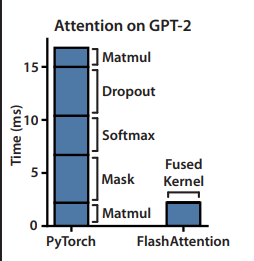


Using this optimisation we can see that the time taken for every step has come down to 160-170 ms and the number of tokens processed has increased to high 24000's per step.

In [ ]:
class CausalSelf_FlashAttention(nn.Module):

    def __init__(self, config):                                                                               # A single class of self attention module with multiple heads instead of
                                                                                                              # iteratively combining multiple single heads of attention
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C (number of channels) = nh * hs
        # e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs=C=768 channels in the Transformer
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        # attention (materializes the large (T,T) matrix for all the queries and keys)
        # att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        # att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))                                     # Replacing all these multiple lines of attention with...
        # att = F.softmax(att, dim=-1)
        # y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = F.scaled_dot_product_attention(q, k, v, is_causal=True)                                           # a much faster, single line of code
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y

class MLP(nn.Module):
                                                                                # A class for Multi Layer Perceptron and is made up of made up of a learned linear projection,
                                                                                # followed by a non-linearity and another learned linear projection
    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu    = nn.GELU(approximate='tanh')
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

class Block(nn.Module):

    def __init__(self, config):                                                 # A block to combine all the previous layers into one block along with residual pathways for the outputs
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelf_FlashAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int = 1024 # max sequence length                                                              # Configuration of the GPT
    vocab_size: int = 50257 # number of tokens: 50,000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dimension

class GPT_FlashAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config                                                     # The GPT itself with the same weights for token embeddings and the language modelling head to save some space just like in GPT-2

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # weight sharing scheme
        self.transformer.wte.weight = self.lm_head.weight

        # init params
        self.apply(self._init_weights)                                          # Initialising the weights

    def _init_weights(self, module):                                            # A small function to initialise the weights with normal distribution and a standard deviation of 1/sqrt(number of residual pathways)
        if isinstance(module, nn.Linear):                                       # If the module is a linear layer
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            std = 0.02
            if hasattr(module, 'NANOGPT_SCALE_INIT'):
                std *= (2 * self.config.n_layer) ** -0.5
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):                                  # else initialising the weights with normal distribution and a standard deviation of 0.02 If the module is an embedding layer
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        # idx is of shape (B, T)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        # forward the token and posisition embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shape (T)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (T, n_embd)
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (B, T, n_embd)
        x = tok_emb + pos_emb
        # forward the blocks of the transformer
        for block in self.transformer.h:
            x = block(x)
        # forward the final layernorm and the classifier
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

import tiktoken

class DataLoaderLite:
    def __init__(self, B, T):
        self.B = B
        self.T = T
                                                                                # A class to create batches for training, it uses tiktoken library for encoding and decoding
        # at init load tokens from disk and store them in memory
        enc = tiktoken.get_encoding('gpt2')
        tokens = enc.encode(formatted_output)
        self.tokens = torch.tensor(tokens)
        print(f"loaded {len(self.tokens)} tokens")
        print(f"1 epoch = {len(self.tokens) // (B * T)} batches")

        # state
        self.current_position = 0

    def next_batch(self):                                                       # A simple function that creates BxT tokens of inputs X and targets Y
        B, T = self.B, self.T
        buf = self.tokens[self.current_position : self.current_position+B*T+1]
        x = (buf[:-1]).view(B, T) # inputs
        y = (buf[1:]).view(B, T) # targets
        # advance the position in the tensor
        self.current_position += B * T
        # if loading the next batch would be out of bounds, reset
        if self.current_position + (B * T + 1) > len(self.tokens):
            self.current_position = 0
        return x, y



In [ ]:
import time                                                                     # The training loop

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"                                                             # Checking if the device is cuda or cpu
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
print(f"using device: {device}")

torch.manual_seed(1337)                                                         # Setting the seed for reproducibility, but I will change the seed from the repo for experimentation
if torch.cuda.is_available():
    torch.cuda.manual_seed(1337)

train_loader = DataLoaderLite(B=8, T=512)                                       # Initialising the data loader with batch and time variables

# get logits
model = GPT_FlashAttention(GPTConfig())                                         # Initialising the GPT model with Flash Attention
model.to(device)
model = torch.compile(model)                                                    # and compiling the model

# optimize!
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
for i in range(50):
    t0 = time.time()
    x, y = train_loader.next_batch()
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    with torch.autocast(device_type=device, dtype=torch.bfloat16):
      logits, loss = model(x, y)
    loss.backward()
    optimizer.step()
    torch.cuda.synchronize() # wait for the GPU to finish work
    t1 = time.time()
    dt = (t1 - t0)*1000 # time difference in miliseconds
    tokens_per_sec = (train_loader.B * train_loader.T) / (t1 - t0)
    print(f"step {i}, loss: {loss.item()}, dt: {dt:.2f}ms, tok/sec: {tokens_per_sec:.2f}")

using device: cuda
loaded 9421129 tokens
1 epoch = 2300 batches
step 0, loss: 10.825286865234375, dt: 23308.06ms, tok/sec: 175.73
step 1, loss: 8.504655838012695, dt: 161.94ms, tok/sec: 25292.63
step 2, loss: 9.433004379272461, dt: 173.78ms, tok/sec: 23570.68
step 3, loss: 8.043529510498047, dt: 167.63ms, tok/sec: 24434.60
step 4, loss: 7.890226364135742, dt: 174.60ms, tok/sec: 23459.83
step 5, loss: 7.772930145263672, dt: 171.44ms, tok/sec: 23891.22
step 6, loss: 7.56185245513916, dt: 167.34ms, tok/sec: 24476.72
step 7, loss: 7.108221054077148, dt: 166.18ms, tok/sec: 24647.28
step 8, loss: 6.996921539306641, dt: 169.10ms, tok/sec: 24222.38
step 9, loss: 6.70263671875, dt: 169.18ms, tok/sec: 24210.60
step 10, loss: 6.543375015258789, dt: 172.57ms, tok/sec: 23734.84
step 11, loss: 6.583255767822266, dt: 169.54ms, tok/sec: 24158.99
step 12, loss: 6.375555038452148, dt: 167.39ms, tok/sec: 24469.68
step 13, loss: 6.4063873291015625, dt: 165.85ms, tok/sec: 24696.92
step 14, loss: 6.01076698

## Fifth Iteration

This Optimisation is a weird heuristical way of optimising the training loop and involves changing the configuration paremeters of the GPT to have numbers that are direct exponents of 2 or multiples of 2.

Using this heuristical optimisation leads to an increase in the tokens processed to high 26000's and a reduction in the time to 155-160 ms.

In [15]:
@dataclass
class GPTConfig_optimised:
    block_size: int = 1024 # max sequence length                                                              # Configuration of the GPT
    vocab_size: int = 50304 # Changing the prior value to a value that is closer to the power of 2 (2^19=50304)
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dimension

In [ ]:
import time                                                                     # The training loop

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"                                                             # Checking if the device is cuda or cpu
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
print(f"using device: {device}")

torch.manual_seed(1337)                                                         # Setting the seed for reproducibility, but I will change the seed from the repo for experimentation
if torch.cuda.is_available():
    torch.cuda.manual_seed(1337)

train_loader = DataLoaderLite(B=8, T=512)                                       # Initialising the data loader with batch and time variables

# get logits
model = GPT_FlashAttention(GPTConfig_optimised())                               # Initialising the GPT model with Flash Attention and better model config parameters
model.to(device)
model = torch.compile(model)                                                    # and compiling the model

# optimize!
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
for i in range(50):
    t0 = time.time()
    x, y = train_loader.next_batch()
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    with torch.autocast(device_type=device, dtype=torch.bfloat16):
      logits, loss = model(x, y)
      loss.backward()
    optimizer.step()
    torch.cuda.synchronize() # wait for the GPU to finish work
    t1 = time.time()
    dt = (t1 - t0)*1000 # time difference in miliseconds
    tokens_per_sec = (train_loader.B * train_loader.T) / (t1 - t0)
    print(f"step {i}, loss: {loss.item()}, dt: {dt:.2f}ms, tok/sec: {tokens_per_sec:.2f}")

using device: cuda
loaded 9421129 tokens
1 epoch = 2300 batches
step 0, loss: 10.929885864257812, dt: 24190.91ms, tok/sec: 169.32
step 1, loss: 8.497459411621094, dt: 150.30ms, tok/sec: 27252.55
step 2, loss: 7.855260848999023, dt: 154.72ms, tok/sec: 26472.97
step 3, loss: 7.667373180389404, dt: 153.49ms, tok/sec: 26685.39
step 4, loss: 10.78965950012207, dt: 158.32ms, tok/sec: 25871.08
step 5, loss: 7.741800308227539, dt: 157.08ms, tok/sec: 26076.61
step 6, loss: 7.366353988647461, dt: 160.87ms, tok/sec: 25462.14
step 7, loss: 6.9412689208984375, dt: 152.81ms, tok/sec: 26805.14
step 8, loss: 6.8524370193481445, dt: 155.69ms, tok/sec: 26309.06
step 9, loss: 6.841870307922363, dt: 154.97ms, tok/sec: 26430.69
step 10, loss: 6.51112174987793, dt: 155.26ms, tok/sec: 26382.31
step 11, loss: 6.639616012573242, dt: 158.94ms, tok/sec: 25770.68
step 12, loss: 6.4639081954956055, dt: 160.91ms, tok/sec: 25454.56
step 13, loss: 6.475238800048828, dt: 157.70ms, tok/sec: 25973.79
step 14, loss: 6.15

##Sixth Iteration

This iteration is not really to increase the efficiency of the training loop but to follow the gpt-3 research paper and to make sure the training will be stable. Including the line to clip the gradient norm prevents the gradients from exploding by scaling them to a maximum norm of 1.0, which helps maintain training stability. This also allows us to monitor the training process by printing the norm variable to check for any inconsistencies.

In [ ]:
import time                                                                       # The training loop

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"                                                                # Checking if the device is cuda or cpu
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
print(f"using device: {device}")

torch.manual_seed(1337)                                                            # Setting the seed for reproducibility, but I will change the seed from the repo for experimentation
if torch.cuda.is_available():
    torch.cuda.manual_seed(1337)

train_loader = DataLoaderLite(B=8, T=512)                                         # Initialising the data loader with batch and time variables

# get logits
model = GPT_FlashAttention(GPTConfig_optimised())                               # Initialising the GPT model with Flash Attention, better model config parameters and
model.to(device)                                                                # gradient clipping
model = torch.compile(model)                                                      # and compiling the model

# optimize!
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
for i in range(50):
    t0 = time.time()
    x, y = train_loader.next_batch()
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    with torch.autocast(device_type=device, dtype=torch.bfloat16):
      logits, loss = model(x, y)
    loss.backward()
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    torch.cuda.synchronize() # wait for the GPU to finish work
    t1 = time.time()
    dt = (t1 - t0)*1000 # time difference in miliseconds
    tokens_per_sec = (train_loader.B * train_loader.T) / (t1 - t0)
    print(f"step {i}, loss: {loss.item()}, norm:{norm:.4f}, dt: {dt:.2f}ms, tok/sec: {tokens_per_sec:.2f}")

using device: cuda
loaded 9421129 tokens
1 epoch = 2300 batches
step 0, loss: 10.929885864257812, norm:13.6124, dt: 20916.46ms, tok/sec: 195.83
step 1, loss: 8.497779846191406, norm:4.9983, dt: 155.59ms, tok/sec: 26325.35
step 2, loss: 7.917259216308594, norm:6.0865, dt: 158.30ms, tok/sec: 25874.62
step 3, loss: 8.511970520019531, norm:14.4262, dt: 157.75ms, tok/sec: 25964.84
step 4, loss: 8.00560188293457, norm:4.3793, dt: 157.54ms, tok/sec: 25999.38
step 5, loss: 7.766864776611328, norm:5.4205, dt: 157.87ms, tok/sec: 25946.09
step 6, loss: 7.382965087890625, norm:5.2992, dt: 164.85ms, tok/sec: 24846.58
step 7, loss: 6.928077697753906, norm:4.6104, dt: 164.92ms, tok/sec: 24836.56
step 8, loss: 6.787617206573486, norm:7.0591, dt: 163.53ms, tok/sec: 25046.72
step 9, loss: 6.522785186767578, norm:3.4579, dt: 158.60ms, tok/sec: 25825.57
step 10, loss: 6.249861717224121, norm:2.6348, dt: 159.47ms, tok/sec: 25685.57
step 11, loss: 6.206721305847168, norm:1.7470, dt: 160.08ms, tok/sec: 25587

## Seventh Iteration

This iteration is also not to increase the efficieny, but to mimic the GPT-3 research paper which includes a variable learning rate. Including a learning rate scheduler adjusts the learning rate during training to improve convergence and performance. The scheduler helps in gradually increasing the learning rate during the initial training phase (warmup), then smoothly decreases it to fine-tune the model as training progresses.

In [ ]:
import time                                                                       # The training loop

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"                                                                # Checking if the device is cuda or cpu
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
print(f"using device: {device}")

torch.manual_seed(1337)                                                            # Setting the seed for reproducibility, but I will change the seed from the repo for experimentation
if torch.cuda.is_available():
    torch.cuda.manual_seed(1337)

train_loader = DataLoaderLite(B=8, T=512)                                         # Initialising the data loader with batch and time variables

# get logits
model = GPT_FlashAttention(GPTConfig_optimised())                                 # Initialising the GPT model with Flash Attention, better model config parameters,
model.to(device)                                                                # gradient clipping and learning rate scheduler
model = torch.compile(model)                                                    # and compiling the model


max_lr = 3e-4
min_lr = max_lr * 0.1
warmup_steps = 10
total_steps = 50

def get_lr(it):
  if it<warmup_steps:
    return max_lr * (it+1) / warmup_steps
  if it>total_steps:
    return min_lr
  decay_ratio = (it-warmup_steps)/(total_steps-warmup_steps)
  assert 0<= decay_ratio <=1
  coeff = 0.5 * (1 + math.cos(math.pi * decay_ratio))
  return min_lr + coeff * (max_lr - min_lr)




# optimize!
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)                         # Initialising the optimiser and training for 50 steps to get a baseline on the speed and efficiency of the current
for i in range(50):                                                                # code with only optimising for the precision of the tensor
    t0 = time.time()
    x, y = train_loader.next_batch()
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    with torch.autocast(device_type=device, dtype=torch.bfloat16):
      logits, loss = model(x, y)
    loss.backward()
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    lr = get_lr(i)
    for param_group in optimizer.param_groups:
      param_group['lr'] = lr
    optimizer.step()
    torch.cuda.synchronize() # wait for the GPU to finish work
    t1 = time.time()
    dt = (t1 - t0)*1000 # time difference in miliseconds
    tokens_per_sec = (train_loader.B * train_loader.T) / (t1 - t0)
    print(f"step {i}, loss: {loss.item()}, lr:{lr:.4f}, norm:{norm:.4f}, dt: {dt:.2f}ms, tok/sec: {tokens_per_sec:.2f}")




using device: cuda
loaded 9421129 tokens
1 epoch = 2300 batches
step 0, loss: 10.929885864257812, lr:0.0000, norm:13.6127, dt: 21421.17ms, tok/sec: 191.21
step 1, loss: 9.665168762207031, lr:0.0001, norm:10.3365, dt: 159.30ms, tok/sec: 25713.13
step 2, loss: 8.563056945800781, lr:0.0001, norm:6.2917, dt: 158.44ms, tok/sec: 25852.19
step 3, loss: 8.170402526855469, lr:0.0001, norm:7.3871, dt: 158.91ms, tok/sec: 25775.55
step 4, loss: 8.371965408325195, lr:0.0001, norm:9.5212, dt: 157.73ms, tok/sec: 25968.72
step 5, loss: 7.910369873046875, lr:0.0002, norm:6.0012, dt: 160.84ms, tok/sec: 25465.62
step 6, loss: 7.670748710632324, lr:0.0002, norm:4.5214, dt: 162.39ms, tok/sec: 25223.23
step 7, loss: 7.086596965789795, lr:0.0002, norm:2.8959, dt: 159.66ms, tok/sec: 25655.04
step 8, loss: 7.6063642501831055, lr:0.0003, norm:30.9106, dt: 160.72ms, tok/sec: 25484.73
step 9, loss: 6.876926422119141, lr:0.0003, norm:6.8212, dt: 161.38ms, tok/sec: 25380.67
step 10, loss: 6.424829483032227, lr:0.00

## Eighth Iteration

This iteration increases the training efficieny by decaying weights of multi dimensional parameters and also fusing the Adam optimiser with the parameters used in the GPT-3 paper. Including this optimisation increases the token rate to 27500-28500 tokens per second while reducing the time to around 148 ms.

In [ ]:
import inspect


class CausalSelf_FlashAttention(nn.Module):

    def __init__(self, config):                                                                               # A single class of self attention module with multiple heads instead of
                                                                                                              # iteratively combining multiple single heads of attention
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C (number of channels) = nh * hs
        # e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs=C=768 channels in the Transformer
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        y = F.scaled_dot_product_attention(q, k, v, is_causal=True)                       # Flash Attention
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y

class MLP(nn.Module):
                                                                                # A class for Multi Layer Perceptron and is made up of made up of a learned linear projection,
                                                                                # followed by a non-linearity and another learned linear projection
    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu    = nn.GELU(approximate='tanh')
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

class Block(nn.Module):

    def __init__(self, config):                                                 # A block to combine all the previous layers into one block along with residual pathways for the outputs
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelf_FlashAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int = 1024 # max sequence length                                                              # Configuration of the GPT
    vocab_size: int = 50304 # Changing the prior value to a value that is closer to the power of 2 (2^19=50304)
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dimension

class GPT_FlashAttention_wdecay(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config                                                     # The GPT itself with the same weights for token embeddings and the language modelling head to save some space just like in GPT-2

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # weight sharing scheme
        self.transformer.wte.weight = self.lm_head.weight

        # init params
        self.apply(self._init_weights)                                          # Initialising the weights

    def _init_weights(self, module):                                            # A small function to initialise the weights with normal distribution and a standard deviation of 1/sqrt(number of residual pathways)
        if isinstance(module, nn.Linear):                                       # If the module is a linear layer
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            std = 0.02
            if hasattr(module, 'NANOGPT_SCALE_INIT'):
                std *= (2 * self.config.n_layer) ** -0.5
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):                                  # else initialising the weights with normal distribution and a standard deviation of 0.02 If the module is an embedding layer
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        # idx is of shape (B, T)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        # forward the token and posisition embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shape (T)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (T, n_embd)
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (B, T, n_embd)
        x = tok_emb + pos_emb
        # forward the blocks of the transformer
        for block in self.transformer.h:
            x = block(x)
        # forward the final layernorm and the classifier
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss


    def configure_optimizers(self, weight_decay, learning_rate, device):
        # start with all of the candidate parameters (that require grad)                            # A function to decay weights of paremeters that are 2 dimensional
        param_dict = {pn: p for pn, p in self.named_parameters()}
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and 'cuda' in device
        print(f"using fused AdamW: {use_fused}")
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=(0.9, 0.95), eps=1e-8, fused=use_fused)
        return optimizer

import tiktoken

class DataLoaderLite:
    def __init__(self, B, T):
        self.B = B
        self.T = T
                                                                                # A class to create batches for training, it uses tiktoken library for encoding and decoding
        # at init load tokens from disk and store them in memory
        enc = tiktoken.get_encoding('gpt2')
        tokens = enc.encode(formatted_output)
        self.tokens = torch.tensor(tokens)
        print(f"loaded {len(self.tokens)} tokens")
        print(f"1 epoch = {len(self.tokens) // (B * T)} batches")

        # state
        self.current_position = 0

    def next_batch(self):                                                       # A simple function that creates BxT tokens of inputs X and targets Y
        B, T = self.B, self.T
        buf = self.tokens[self.current_position : self.current_position+B*T+1]
        x = (buf[:-1]).view(B, T) # inputs
        y = (buf[1:]).view(B, T) # targets
        # advance the position in the tensor
        self.current_position += B * T
        # if loading the next batch would be out of bounds, reset
        if self.current_position + (B * T + 1) > len(self.tokens):
            self.current_position = 0
        return x, y



In [ ]:
import time                                                                       # The training loop

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"                                                                # Checking if the device is cuda or cpu
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
print(f"using device: {device}")

torch.manual_seed(1337)                                                            # Setting the seed for reproducibility, but I will change the seed from the repo for experimentation
if torch.cuda.is_available():
    torch.cuda.manual_seed(1337)

train_loader = DataLoaderLite(B=8, T=512)                                         # Initialising the data loader with batch and time variables


model = GPT_FlashAttention_wdecay(GPTConfig_optimised())                        # Initialising the GPT model with Flash Attention, better model config parameters,
model.to(device)                                                                # gradient clipping and learning rate scheduler
model = torch.compile(model)                                                    # and compiling the model


max_lr = 3e-4
min_lr = max_lr * 0.1
warmup_steps = 10
total_steps = 50

def get_lr(it):
  if it<warmup_steps:
    return max_lr * (it+1) / warmup_steps
  if it>total_steps:
    return min_lr
  decay_ratio = (it-warmup_steps)/(total_steps-warmup_steps)
  assert 0<= decay_ratio <=1
  coeff = 0.5 * (1 + math.cos(math.pi * decay_ratio))
  return min_lr + coeff * (max_lr - min_lr)




# optimize!
# optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
optimizer = model.configure_optimizers(weight_decay=0.1, learning_rate=6e-4, device=device)
                                                                                # Along with a new optimizer that decays multi dimensional weights
for i in range(50):
    t0 = time.time()
    x, y = train_loader.next_batch()
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    with torch.autocast(device_type=device, dtype=torch.bfloat16):
      logits, loss = model(x, y)
    loss.backward()
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    lr = get_lr(i)
    for param_group in optimizer.param_groups:
      param_group['lr'] = lr
    optimizer.step()
    torch.cuda.synchronize() # wait for the GPU to finish work
    t1 = time.time()
    dt = (t1 - t0)*1000 # time difference in miliseconds
    tokens_per_sec = (train_loader.B * train_loader.T) / (t1 - t0)
    print(f"step {i}, loss: {loss.item()}, lr:{lr:.4f}, norm:{norm:.4f}, dt: {dt:.2f}ms, tok/sec: {tokens_per_sec:.2f}")




using device: cuda
loaded 9421129 tokens
1 epoch = 2300 batches
num decayed parameter tensors: 50, with 124,354,560 parameters
num non-decayed parameter tensors: 98, with 121,344 parameters
using fused AdamW: True
step 0, loss: 10.929885864257812, lr:0.0000, norm:13.6124, dt: 21353.32ms, tok/sec: 191.82
step 1, loss: 9.664558410644531, lr:0.0001, norm:10.3364, dt: 139.09ms, tok/sec: 29449.35
step 2, loss: 8.567590713500977, lr:0.0001, norm:6.3289, dt: 139.47ms, tok/sec: 29367.65
step 3, loss: 8.180635452270508, lr:0.0001, norm:7.4492, dt: 140.13ms, tok/sec: 29229.00
step 4, loss: 8.348896026611328, lr:0.0001, norm:9.2778, dt: 139.76ms, tok/sec: 29308.08
step 5, loss: 7.901899337768555, lr:0.0002, norm:5.9046, dt: 139.76ms, tok/sec: 29306.73
step 6, loss: 7.673633575439453, lr:0.0002, norm:4.6334, dt: 144.25ms, tok/sec: 28395.77
step 7, loss: 7.086617946624756, lr:0.0002, norm:2.8838, dt: 139.84ms, tok/sec: 29291.14
step 8, loss: 7.610875606536865, lr:0.0003, norm:32.0036, dt: 139.66ms,

## Ninth Iteration

This is the final Iteration of the optimisation that I will include, but in the video Andrej proceeds further after this step to show how the training can be distributed over a multi GPU cluster and also shows how to traing a Billion Token Dataset.

Before this step, gradients i.e, loss.backward() was called during every step of the iteration, but this is not ideal as there will be a lot of reads and writes to the memory.

Collecting all the gradients for a smaller mini batch while making sure it is normalised is better because it is more efficient and allows for training with an effectively larger batch size without requiring more GPU memory.

This might be the best efficiency that we can achieve and will be using the same configuration to train the model on custom 'Jeopardy' data.

In [ ]:
import time                                                                     # The training loop

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"                                                             # Checking if the device is cuda or cpu
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
print(f"using device: {device}")

torch.manual_seed(1337)                                                         # Setting the seed for reproducibility, but I will change the seed from the repo for experimentation
if torch.cuda.is_available():
    torch.cuda.manual_seed(1337)

train_loader = DataLoaderLite(B=8, T=512)                                       # Initialising the data loader with batch and time variables

total_batch_size = 524288
B=8
T=512
assert total_batch_size % (B * T) == 0
grad_accum_steps = total_batch_size // (B * T)

print(f"total desired batch size: {total_batch_size}")
print(f"batch size per step: {grad_accum_steps}")



model = GPT_FlashAttention_wdecay(GPTConfig_optimised())                        # Initialising the GPT model with Flash Attention, better model config parameters,
model.to(device)                                                                # gradient clipping and learning rate scheduler
model = torch.compile(model)                                                    # and compiling the model


max_lr = 3e-4
min_lr = max_lr * 0.1
warmup_steps = 10
total_steps = 50

def get_lr(it):
  if it<warmup_steps:
    return max_lr * (it+1) / warmup_steps
  if it>total_steps:
    return min_lr
  decay_ratio = (it-warmup_steps)/(total_steps-warmup_steps)
  assert 0<= decay_ratio <=1
  coeff = 0.5 * (1 + math.cos(math.pi * decay_ratio))
  return min_lr + coeff * (max_lr - min_lr)


# optimize!
# optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
optimizer = model.configure_optimizers(weight_decay=0.1, learning_rate=6e-4, device=device)
                                                                                # Along with a new optimizer that decays multi dimensional weights
for i in range(50):
    t0 = time.time()
    optimizer.zero_grad()
    loss_accum = 0.0
    for micro_step in range(grad_accum_steps):                                  # With an inner for loop for gradient accumulation
      x, y = train_loader.next_batch()
      x, y = x.to(device), y.to(device)
      with torch.autocast(device_type=device, dtype=torch.bfloat16):
        logits, loss = model(x, y)
      loss = loss/grad_accum_steps
      loss_accum += loss.detach()
      loss.backward()
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    lr = get_lr(i)
    for param_group in optimizer.param_groups:
      param_group['lr'] = lr
    optimizer.step()
    torch.cuda.synchronize() # wait for the GPU to finish work
    t1 = time.time()
    dt = (t1 - t0)*1000 # time difference in miliseconds
    tokens_per_sec = (train_loader.B * train_loader.T * grad_accum_steps) / (t1 - t0)
    print(f"step {i}, loss: {loss_accum.item():.6f}, lr:{lr:.4f}, norm:{norm:.4f}, dt: {dt:.2f}ms, tok/sec: {tokens_per_sec:.2f}")




using device: cuda
total desired batch size: 524288
batch size per step: 128
num decayed parameter tensors: 50, with 124,354,560 parameters
num non-decayed parameter tensors: 98, with 121,344 parameters
using fused AdamW: True
step 0, loss: 10.924479, lr:0.0000, norm:13.5004, dt: 36957.07ms, tok/sec: 14186.40
step 1, loss: 9.716283, lr:0.0001, norm:9.6732, dt: 15718.50ms, tok/sec: 33354.84
step 2, loss: 8.631975, lr:0.0001, norm:6.0026, dt: 15660.54ms, tok/sec: 33478.29
step 3, loss: 8.216371, lr:0.0001, norm:7.1938, dt: 15665.63ms, tok/sec: 33467.40
step 4, loss: 8.269403, lr:0.0001, norm:9.8359, dt: 15616.85ms, tok/sec: 33571.94
step 5, loss: 7.811697, lr:0.0002, norm:6.2773, dt: 15655.45ms, tok/sec: 33489.16
step 6, loss: 7.569506, lr:0.0002, norm:4.6454, dt: 15791.55ms, tok/sec: 33200.54
step 7, loss: 7.208411, lr:0.0002, norm:2.9081, dt: 15901.71ms, tok/sec: 32970.54
step 8, loss: 7.747791, lr:0.0003, norm:31.4332, dt: 15932.34ms, tok/sec: 32907.15
step 9, loss: 7.042092, lr:0.000

# Training on custom data

Loading the data from the json on google drive and appending the data into the formatted_output variable

In [5]:
import json

with open('/content/drive/MyDrive/Train Data/JEOPARDY_QUESTIONS1.json', 'r') as file:
    data = json.load(file)

formatted_output = ""

for entry in data:
    formatted_output += f"Question:\n{entry['question']}\n\n"
    formatted_output += f"Value:\n{entry['value']}\n\n"
    formatted_output += f"Answer:\n{entry['answer']}\n\n"


Printing the first two rounds of jeopardy in the training data

In [6]:
print(formatted_output[:297])

Question:
'For the last 8 years of his life, Galileo was under house arrest for espousing this man's theory'

Value:
$200

Answer:
Copernicus

Question:
'No. 2: 1912 Olympian; football star at Carlisle Indian School; 6 MLB seasons with the Reds, Giants & Braves'

Value:
$200

Answer:
Jim Thorpe




Getting the token count for the dataset

In [7]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

tokens = tokenizer.encode(formatted_output)

num_tokens = len(tokens)

print("Number of tokens:", num_tokens)


Number of tokens: 9421129


Using all the optimsations we previously discovered to create a custom GPT with a different seed.

In [12]:
import inspect
import math                                                                     # Necessary Imports
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F


class CausalSelf_FlashAttention(nn.Module):

    def __init__(self, config):                                                  # A single class of self attention module with multiple heads instead of
                                                                                 # iteratively combining multiple single heads of attention
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size()
        # nh is "number of heads", hs is "head size", and C (number of channels) = nh * hs
        # e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs=C=768 channels in the Transformer
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        y = F.scaled_dot_product_attention(q, k, v, is_causal=True)                                # Using Flash Attention optimsation
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.c_proj(y)
        return y

class MLP(nn.Module):
                                                                                # A class for Multi Layer Perceptron and is made up of made up of a linear projection,
                                                                                # followed by a non-linearity and another linear projection
    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu    = nn.GELU(approximate='tanh')
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x


class Block(nn.Module):

    def __init__(self, config):                                                 # A block to combine all the previous layers into one block along with residual pathways for the outputs
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelf_FlashAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

@dataclass
class GPTConfig_optimised:
    block_size: int = 1024 # max sequence length                                # Configuration of the GPT with
    vocab_size: int = 50304 # A better number as 50304 is 2^19
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dimension

class GPT_FlashAttention_wdecay(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config                                                    # The GPT itself with the same weights for token embeddings and the language modelling head
                                                                                # to save some space just like in GPT-2
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # weight sharing scheme
        self.transformer.wte.weight = self.lm_head.weight

        self.apply(self._init_weights)                                          # Initialising the weights

    def _init_weights(self, module):                                            # A small function to initialise the weights with normal distribution and a standard deviation of
        if isinstance(module, nn.Linear):                                       # 1/sqrt(number of residual pathways) If the module is a linear layer
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            std = 0.02
            if hasattr(module, 'NANOGPT_SCALE_INIT'):
                std *= (2 * self.config.n_layer) ** -0.5
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):                                  # else initialising the weights with normal distribution and a standard deviation of 0.02 If the module is an embedding layer
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        # idx is of shape (B, T)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (T, n_embd)
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (B, T, n_embd)
        x = tok_emb + pos_emb
        # forward the blocks of the transformer
        for block in self.transformer.h:
            x = block(x)
        # forward the final layernorm and the classifier
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss


    def configure_optimizers(self, weight_decay, learning_rate, device):        # A function to separate the multi dimensional weights(>2 dimensions) with the single dimensional weights
        # start with all of the candidate parameters (that require grad)
        param_dict = {pn: p for pn, p in self.named_parameters()}
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # i.e. all weights in matmuls + embeddings decay, all biases and layernorms won't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and 'cuda' in device
        print(f"using fused AdamW: {use_fused}")
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=(0.9, 0.95), eps=1e-8, fused=use_fused)
        return optimizer

import tiktoken


class DataLoaderLite:
    def __init__(self, B, T):
        self.B = B
        self.T = T
                                                                                # A class to create batches for training, it uses tiktoken library for encoding and decoding
        # at init load tokens from disk and store them in memory
        enc = tiktoken.get_encoding('gpt2')
        tokens = enc.encode(formatted_output)
        self.tokens = torch.tensor(tokens)
        print(f"loaded {len(self.tokens)} tokens")
        print(f"1 epoch = {len(self.tokens) // (B * T)} batches")

        self.current_position = 0

    def next_batch(self):                                                       # A simple function that creates BxT tokens of inputs X and targets Y
        B, T = self.B, self.T
        buf = self.tokens[self.current_position : self.current_position+B*T+1]
        x = (buf[:-1]).view(B, T) # inputs
        y = (buf[1:]).view(B, T) # targets
        self.current_position += B * T
        if self.current_position + (B * T + 1) > len(self.tokens):
            self.current_position = 0
        return x, y



From the Ninth Iteration we can see that the highest throughput that we can achieve with all the optimisations combined is approximately 33500 tokens per step and since we have 9421129 total tokens in out training set, we will need 281(9421129/33500) steps of training to cover the entire training set.

So I will run the training loop for 285 steps for good measure to cover the entire training set.

In [13]:
import time                                                                       # The training loop

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"                                                                # Checking if the device is cuda or cpu
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
print(f"using device: {device}")

torch.manual_seed(1450)                                                            # Setting the seed for reproducibility, but I will change the seed from the repo for experimentation
if torch.cuda.is_available():
    torch.cuda.manual_seed(1450)

train_loader = DataLoaderLite(B=8, T=512)

total_batch_size = 524288
B=8
T=512
assert total_batch_size % (B * T) == 0
grad_accum_steps = total_batch_size // (B * T)

print(f"total desired batch size: {total_batch_size}")
print(f"batch size per step: {grad_accum_steps}")




model = GPT_FlashAttention_wdecay(GPTConfig_optimised())                         # Initialising the GPT model with flash attention with weight decay and optimised parameters
model.to(device)
model = torch.compile(model)


max_lr = 3e-4
min_lr = max_lr * 0.1
warmup_steps = 50
total_steps = 285                                                               # 283 steps to cover the entire training set

def get_lr(it):
  if it<warmup_steps:
    return max_lr * (it+1) / warmup_steps
  if it>total_steps:
    return min_lr
  decay_ratio = (it-warmup_steps)/(total_steps-warmup_steps)
  assert 0<= decay_ratio <=1
  coeff = 0.5 * (1 + math.cos(math.pi * decay_ratio))
  return min_lr + coeff * (max_lr - min_lr)


optimizer = model.configure_optimizers(weight_decay=0.1, learning_rate=6e-4, device=device)

for i in range(total_steps):
    t0 = time.time()
    optimizer.zero_grad()
    loss_accum = 0.0
    for micro_step in range(grad_accum_steps):
      x, y = train_loader.next_batch()
      x, y = x.to(device), y.to(device)
      with torch.autocast(device_type=device, dtype=torch.bfloat16):
        logits, loss = model(x, y)
      loss = loss/grad_accum_steps
      loss_accum += loss.detach()
      loss.backward()
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    lr = get_lr(i)
    for param_group in optimizer.param_groups:
      param_group['lr'] = lr
    optimizer.step()
    torch.cuda.synchronize() # wait for the GPU to finish work
    t1 = time.time()
    dt = (t1 - t0)*1000 # time difference in miliseconds
    tokens_per_sec = (train_loader.B * train_loader.T * grad_accum_steps) / (t1 - t0)
    print(f"step {i}, loss: {loss_accum.item():.6f}, lr:{lr:.4f}, norm:{norm:.4f}, dt: {dt:.2f}ms, tok/sec: {tokens_per_sec:.2f}")





using device: cuda
loaded 9421129 tokens
1 epoch = 2300 batches
total desired batch size: 524288
batch size per step: 128
num decayed parameter tensors: 50, with 124,354,560 parameters
num non-decayed parameter tensors: 98, with 121,344 parameters
using fused AdamW: True
step 0, loss: 10.904790, lr:0.0000, norm:14.4760, dt: 55575.65ms, tok/sec: 9433.77
step 1, loss: 10.601091, lr:0.0000, norm:14.0213, dt: 14482.57ms, tok/sec: 36201.32
step 2, loss: 10.036264, lr:0.0000, norm:12.4502, dt: 14595.89ms, tok/sec: 35920.26
step 3, loss: 9.395319, lr:0.0000, norm:9.5807, dt: 14816.86ms, tok/sec: 35384.56
step 4, loss: 8.856178, lr:0.0000, norm:6.9327, dt: 15040.43ms, tok/sec: 34858.58
step 5, loss: 8.536637, lr:0.0000, norm:4.7728, dt: 15278.85ms, tok/sec: 34314.62
step 6, loss: 8.313064, lr:0.0000, norm:5.1949, dt: 15420.74ms, tok/sec: 33998.89
step 7, loss: 8.079925, lr:0.0000, norm:4.4964, dt: 15740.91ms, tok/sec: 33307.34
step 8, loss: 7.939632, lr:0.0001, norm:6.3012, dt: 15634.13ms, tok

In [24]:
model.eval()
num_return_sequences = 10
max_length = 500

enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode("Question:")
tokens = torch.tensor(tokens, dtype=torch.long)
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)
x = tokens.to(device)

torch.set_float32_matmul_precision('high')

# generate!
# set the seed to 42
torch.manual_seed(42)
torch.cuda.manual_seed(42)

enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode("Question:")
tokens = torch.tensor(tokens, dtype=torch.long)
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)
x = tokens.to(device)
while x.size(1) < max_length:
    with torch.no_grad():
        logits, _ = model(x)
        logits = logits[:, -1, :]
        probs = F.softmax(logits, dim=-1)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
        ix = torch.multinomial(topk_probs, 1) # (B, 1)
        xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
        x = torch.cat((x, xcol), dim=1)

# print the generated text
for i in range(num_return_sequences):
    tokens = x[i, :max_length].tolist()
    decoded = enc.decode(tokens)
    print(">"+ decoded)

>Question:
'If you can tell the way at the only woman, she are not be in the most common type of a woman'

Value:
$500

Answer:
a

Question:
'A British king of these, it's one of the British is the title "Rude the time"'

Value:
$500

Answer:
s/diamond

Question:
'The World War for this country's official nation, and 2 miles of a "Tales"--it'

Value:
$500

Answer:
(John) Br. Paul Franklin

Question:
'(<a href="http://www.j-archive.com/media/2004-03_J_19.jpg" target="_blank">Hi, I'm in <a>) You'll find the number of the most common in 1789:<br />"I'm just as T. president'

Value:
$200

Answer:
Hermann

Question:
'A. I played a great one of an animal, "D. I will come out of all"'

Value:
$200

Answer:
the H.Sri

Question:
'From the name of this "The World War I'm and the U.  At Love"'

Value:
$200

Answer:
the S.)

Question:
'One" in this song was discovered the '40s, for a certain, a synonym for "and"'

Value:
$200

Answer:
Lion

Question:
'The "In June of "The Goth"'

Value:
$400

Answ

Looking at the outputs, we can see that the model is able to recognise the pattern quite well but the comprehensibility of questions, values and answers need more work. This is mainly because I'm only training the model for one epoch as I cannot afford to train the model longer so training the model for multiple epochs will definetly help.

And you will also notice that currently the model is only completing the sentences i.e, it will blabber on about the next possible token and is not the chatbot that is commercially available. To get the model to behave like a chatbot, firstly the model will have to be trained on trillions and trillions of tokens(the model in the notebook is only trained on ~30 million tokens) and alignment of the model has to be done and alignment is a very tedious and very very expensive task that only huge companies like openai, google and microsoft can afford. Below is a photo describing the high level steps of allignment that openAI had to do for gpt-3 to behave like a chatbot.

image_2024-06-17_223454728.png

source: https://openai.com/index/chatgpt/

In [25]:
model.eval()
num_return_sequences = 15
max_length = 500

enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode("Question:")
tokens = torch.tensor(tokens, dtype=torch.long)
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)
x = tokens.to(device)

torch.set_float32_matmul_precision('high')

# generate!
# set the seed to 42
torch.manual_seed(42)
torch.cuda.manual_seed(42)

enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode("Question:")
tokens = torch.tensor(tokens, dtype=torch.long)
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)
x = tokens.to(device)
while x.size(1) < max_length:
    with torch.no_grad():
        logits, _ = model(x)
        logits = logits[:, -1, :]
        probs = F.softmax(logits, dim=-1)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
        ix = torch.multinomial(topk_probs, 1) # (B, 1)
        xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
        x = torch.cat((x, xcol), dim=1)

# print the generated text
for i in range(num_return_sequences):
    tokens = x[i, :max_length].tolist()
    decoded = enc.decode(tokens)
    print(">"+ decoded)

>Question:
'If you can tell the way at the only woman, she are not be in the most common type of a woman'

Value:
$500

Answer:
a

Question:
'A British king of these, it's one of the British is the title "Rude the time"'

Value:
$500

Answer:
s/diamond

Question:
'The King of her book, one at its logo is to say "F.Y.  With The A Tale"'

Value:
$500

Answer:
Polar in Germontas

Question:
'While the last name this "Joh" has all the "The Wizard" this city'

Value:
$500

Answer:
Meryl Streis Khaner

Question:
'In the one of the '50 million-word title of "The Sound at World" character of the World War'

Value:
None

Answer:
"E. Dequeline"

Question:
'The only part of the most of the most "S.D.'

Value:
$200

Answer:
H. Roosevelt

Question:
'The only to a type of the first 2 of the 4-S.  (6 for a young president that that of this'

Value:
$200

Answer:
Fol

Question:
'It's <a href="http://www.j-archive.com/media/1998-22_DJ_07.jpg" target="_blank">Kelly of the clue from my life in the World W

###Saving the model

In [26]:
save_path = r'/content/drive/MyDrive/Trained-Nano-GPT/Nano-GPT-jeopardy-model-1.pth'

checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'config': model.config
}

torch.save(checkpoint, save_path)
print(f"Model saved to {save_path}")

Model saved to /content/drive/MyDrive/Trained-Nano-GPT/Nano-GPT-jeopardy-model-1.pth
